# Subreddit Predictor

Implementation of a model that predicts whether input posts are from 1 of 4 different programming subreddits. Uses a multiclass Bernoulli Naive Bayes model with stop words and bagging

## Install (Most) Dependencies

In [ ]:
# Installing natural language toolkit
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
#import list
import numpy as np
import random as rand
import pandas as pd
import seaborn as sns
import string
from scipy import sparse
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, f_regression, mutual_info_regression, SelectPercentile
import math as ma
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import time
print("Finished importing!")

Finished importing!


## Load The Dataset

In [ ]:
import pandas as pd
import requests
from io import StringIO
import io
from google.colab import files

#imports train set from google drive
url='https://drive.google.com/file/d/1cqbryoylVGKr9LZ_5PhJFhvkbiw8sCH2/view?usp=sharing'

file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url2 = requests.get(dwn_url).text
csv_raw = StringIO(url2)


df = pd.read_csv(csv_raw)
df.head()

#imports test set from computer local
uploaded = files.upload()
df2 = pd.read_csv(io.BytesIO(uploaded['test.csv']), encoding='cp1252')
print(df2.iloc[:,1].to_numpy())
test_set = df2.iloc[:,1].to_numpy()

Saving test.csv to test.csv
['> Ezno started off as pet project to re-implementing the features of TSC in Rust\n\nWhile reading that article, Rust definitely came to mind a few times. Looks interesting, although the example with any is really not the best.'
 '>This differs from TypeScript which treats things like the return annotation as the source of truth, allowing this to be validly checked:\n\nTypescript doesn\'t treat return annotations as the source of truth.\n\nExample: [https://www.typescriptlang.org/play?#code/GYVwdgxgLglg9mABATwBQEMBciwgLYBGApgE4CU2AzlCTGAOaIDeAUAJAlFQglLosBfIA](https://www.typescriptlang.org/play?#code/GYVwdgxgLglg9mABATwBQEMBciwgLYBGApgE4CU2AzlCTGAOaIDeAUAJAlFQglLosBfIA)\n\nYou just don\'t understand what "any" is in Typescript. "any" means that it satisfies any type, all types. It can be string, it can be number, it can be violet sky. What you most likely wanted to do here should be written like this\n\n    function y(a: unknown): string {\n      // error,

## Custom Stop Words

In [ ]:
#custom word list to improve accuracy to filter out specific words
#partially duplicated in the imported words list
switcher = {
  # All pronouns and associated words
  "i": True,
  "i'll": True,
  "i'd": True,
  "i'm": True,
  "i've": True,
  "ive": True,
  "me": True,
  "myself": True,
  "you": True,
  "you'll": True,
  "you'd": True,
  "you're": True,
  "you've": True,
  "yourself": True,
  "he": True,
  "he'll": True,
  "he'd": True,
  "he's": True,
  "him": True,
  "she": True,
  "she'll": True,
  "she'd": True,
  "she's": True,
  "her": True,
  "it": True,
  "it'll": True,
  "it'd": True,
  "it's": True,
  "itself": True,
  "oneself": True,
  "we": True,
  "we'll": True,
  "we'd": True,
  "we're": True,
  "we've": True,
  "us": True,
  "ourselves": True,
  "they": True,
  "they'll": True,
  "they'd": True,
  "they're": True,
  "they've": True,
  "them": True,
  "themselves": True,            
  "everyone": True,
  "everyone's": True,
  "everybody": True,
  "everybody's": True,
  "someone": True,
  "someone's": True,
  "somebody": True,
  "somebody's": True,
  "nobody": True,
  "nobody's": True,
  "anyone": True,
  "anyone's": True,
  "everything": True,
  "everything's": True,
  "something": True,
  "something's": True,
  "nothing": True,
  "nothing's": True,
  "anything": True,
  "anything's": True,
  # All determiners and associated words
  "a": True,
  "an": True,
  "the": True,
  "this": True,
  "that": True,
  "that's": True,
  "these": True,
  "those": True,
  "my": True,
  "your": True,
  "yours": True,
  "his": True,
  "hers": True,
  "its": True,
  "our": True,
  "ours": True,
  "own": True,
  "their": True,
  "theirs": True,
  "few": True,
  "much": True,
  "many": True,
  "lot": True,
  "lots": True,
  "some": True,
  "any": True,
  "enough": True,
  "all": True,
  "both": True,
  "half": True,
  "either": True,
  "neither": True,
  "each": True,
  "every": True,
  "certain": True,
  "other": True,
  "another": True,
  "such": True,
  "several": True,
  "multiple": True,
  # "what": True,    #Dealt with later on
  "rather": True,
  "quite": True,
  # All prepositions
  "aboard": True,
  "about": True,
  "above": True,
  "across": True,
  "after": True,
  "against": True,
  "along": True,
  "amid": True,
  "amidst": True,
  "among": True,
  "amongst": True,
  "anti": True,
  "around": True,
  "as": True,
  "at": True,
  "away": True,
  "before": True,
  "behind": True,
  "below": True,
  "beneath": True,
  "beside": True,
  "besides": True,
  "between": True,
  "beyond": True,
  "but": True,
  "by": True,
  "concerning": True,
  "considering": True,
  "despite": True,
  "down": True,
  "during": True,
  "except": True,
  "excepting": True,
  "excluding": True,
  "far": True,
  "following": True,
  "for": True,
  "from": True,
  "here": True,
  "here's": True,
  "in": True,
  "inside": True,
  "into": True,
  "left": True,
  "like": True,
  "minus": True,
  "near": True,
  "of": True,
  "off": True,
  "on": True,
  "onto": True,
  "opposite": True,
  "out": True,
  "outside": True,
  "over": True,
  "past": True,
  "per": True,
  "plus": True,
  "regarding": True,
  "right": True,
  "since": True,
  "than": True,
  "there": True,
  "there's": True,
  "through": True,
  "to": True,
  "toward": True,
  "towards": True,
  "under": True,
  "underneath": True,
  "unlike": True,
  "until": True,
  "up": True,
  "upon": True,
  "versus": True,
  "via": True,
  "with": True,
  "within": True,
  "without": True,
  # Irrelevant verbs
  "may": True,
  "might": True,
  "will": True,
  "won't": True,
  "would": True,
  "wouldn't": True,
  "can": True,
  "can't": True,
  "cannot": True,
  "could": True,
  "couldn't": True,
  "should": True,
  "shouldn't": True,
  "must": True,
  "must've": True,
  "be": True,
  "being": True,
  "been": True,
  "am": True,
  "are": True,
  "aren't": True,
  "ain't": True,
  "is": True,
  "isn't": True,
  "was": True,
  "wasn't": True,
  "were": True,
  "weren't": True,
  "do": True,
  "doing": True,
  "don't": True,
  "does": True,
  "doesn't": True,
  "did": True,
  "didn't": True,
  "done": True,
  "have": True,
  "haven't": True,
  "having": True,
  "has": True,
  "hasn't": True,
  "had": True,
  "hadn't": True,
  "get": True,
  "getting": True,
  "gets": True,
  "got": True,
  "gotten": True,
  "go": True,
  "going": True,
  "gonna": True,
  "goes": True,
  "went": True,
  "gone": True,
  "make": True,
  "making": True,
  "makes": True,
  "made": True,
  "take": True,
  "taking": True,
  "takes": True,
  "took": True,
  "taken": True,
  "need": True,
  "needing": True,
  "needs": True,
  "needed": True,
  "use": True,
  "using": True,
  "uses": True,
  "used": True,
  "want": True,
  "wanna": True,
  "wanting": True,
  "wants": True,
  "let": True,
  "lets": True,
  "letting": True,
  "let's": True,
  "suppose": True,
  "supposing": True,
  "supposes": True,
  "supposed": True,
  "seem": True,
  "seeming": True,
  "seems": True,
  "seemed": True,
  "say": True,
  "saying": True,
  "says": True,
  "said": True,
  "know": True,
  "knowing": True,
  "knows": True,
  "knew": True,
  "known": True,
  "look": True,
  "looking": True,
  "looked": True,
  "think": True,
  "thinking": True,
  "thinks": True,
  "thought": True,
  "feel": True,
  "feels": True,
  "felt": True,
  "based": True,
  "put": True,
  "puts": True,
  "begin": True,
  "began": True,
  "begun": True,
  "begins": True,
  "wanted": True,
  "like": True,  
  "feel": True,
  "believe": True,
  "understand": True,
  "shall": True,
  "regard": True,
  "regards": True,
  "regarding": True,
  # Question words and associated words
  "who": True,
  "who's": True,
  "who've": True,
  "who'd": True,
  "whoever": True,
  "whoever's": True,
  "whom": True,
  "whomever": True,
  "whomever's": True,
  "whose": True,
  "whosever": True,
  "whosever's": True,
  "when": True,
  "whenever": True,
  "which": True,
  "whichever": True,
  "where": True,
  "where's": True,
  "where'd": True,
  "wherever": True,
  "why": True,
  "why's": True,
  "why'd": True,
  "whyever": True,
  "what": True,
  "what's": True,
  "whatever": True,
  "whence": True,
  "how": True,
  "how's": True,
  "how'd": True,
  "however": True,
  "whether": True,
  "whatsoever": True,
  # Connector words and irrelevant adverbs
  "and": True,
  "or": True,
  "not": True,
  "because": True,
  "also": True,
  "always": True,
  "never": True,
  "only": True,
  "really": True,
  "very": True,
  "greatly": True,
  "extremely": True,
  "somewhat": True,
  "no": True,
  "nope": True,
  "nah": True,
  "yes": True,
  "yep": True,
  "yeh": True,
  "yeah": True,
  "maybe": True,
  "perhaps": True,
  "more": True,
  "most": True,
  "less": True,
  "least": True,
  "good": True,
  "great": True,
  "well": True,
  "better": True,
  "best": True,
  "bad": True,
  "worse": True,
  "worst": True,
  "too": True,
  "thru": True,
  "though": True,
  "although": True,
  "yet": True,
  "already": True,
  "then": True,
  "even": True,
  "now": True,
  "sometimes": True,
  "still": True,
  "together": True,
  "altogether": True,
  "entirely": True,
  "fully": True,
  "entire": True,
  "whole": True,
  "completely": True,
  "utterly": True,
  "seemingly": True,
  "apparently": True,
  "clearly": True,
  "obviously": True,
  "actually": True,
  "actual": True,
  "usually": True,
  "usual": True,
  "literally": True,
  "honestly": True,
  "absolutely": True,
  "definitely": True,
  "generally": True,
  "totally": True,
  "finally": True,
  "basically": True,
  "essentially": True,
  "fundamentally": True,
  "automatically": True,
  "immediately": True,
  "necessarily": True,
  "primarily": True,
  "normally": True,
  "perfectly": True,
  "constantly": True,
  "particularly": True,
  "eventually": True,
  "hopefully": True,
  "mainly": True,
  "typically": True,
  "specifically": True,
  "differently": True,
  "appropriately": True,
  "plenty": True,
  "certainly": True,
  "unfortunately": True,
  "ultimately": True,
  "unlikely": True,
  "likely": True,
  "potentially": True,
  "fortunately": True,
  "personally": True,
  "directly": True,
  "indirectly": True,
  "nearly": True,
  "closely": True,
  "slightly": True,
  "probably": True,
  "possibly": True,
  "especially": True,
  "frequently": True,
  "thankfully": True,
  "often": True,
  "oftentimes": True,
  "seldom": True,
  "rarely": True,
  "sure": True,
  "while": True,
  "whilst": True,
  "able": True,
  "unable": True,
  "else": True,
  "ever": True,
  "once": True,
  "twice": True,
  "thrice": True,
  "almost": True,
  "again": True,
  "instead": True,
  "next": True,
  "previous": True,
  "unless": True,
  "somehow": True,
  "anyhow": True,
  "anywhere": True,
  "somewhere": True,
  "everywhere": True,
  "elsewhere": True,
  "anytime": True,
  "nowhere": True,
  "further": True,
  "anymore": True,
  "later": True,
  "ago": True,
  "ahead": True,
  "just": True,
  "same": True,
  "different": True,
  "big": True,
  "small": True,
  "little": True,
  "tiny": True,
  "large": True,
  "huge": True,
  "pretty": True,
  "mostly": True,
  "anyway": True,
  "anyways": True,
  "otherwise": True,
  "regardless": True,
  "needless": True,
  "throughout": True,
  "additionally": True,
  "moreover": True,
  "furthermore": True,
  "therefore": True,
  "thereof": True,
  "meanwhile": True,
  "likewise": True,
  "afterwards": True,
  "nice": True,
  "nicer": True,
  "nicest": True,
  "glad": True,
  "fine": True,
  # Irrelevant nouns
  "thing": True,
  "thing's": True,
  "things": True,
  "stuff": True,
  "other's": True,
  "others": True,
  "another's": True,
  "total": True,
  "true": True,
  "false": True,
  "none": True,
  "way": True,
  "kind": True,
  # Lettered numbers and order
  "zero": True,
  "zeros": True,
  "zeroes": True,
  "one": True,
  "ones": True,
  "two": True,
  "three": True,
  "four": True,
  "five": True,
  "six": True, 
  "seven": True,
  "eight": True,
  "nine": True,
  "ten": True,
  "twenty": True,
  "thirty": True,
  "forty": True,
  "fifty": True,
  "sixty": True,
  "seventy": True,
  "eighty": True,
  "ninety": True,
  "hundred": True,
  "hundreds": True,
  "thousand": True,
  "thousands": True,
  "million": True,
  "millions": True,
  "first": True,
  "last": True,
  "second": True,
  "third": True,
  "fourth": True,
  "fifth": True,
  "sixth": True,
  "seventh": True,
  "eigth": True,
  "ninth": True,
  "tenth": True,
  "firstly": True,
  "secondly": True,
  "thirdly": True,
  "lastly": True,
  # Greetings and slang
  "hello": True,
  "hi": True,
  "hey": True,
  "sup": True,
  "yo": True,
  "greetings": True,
  "please": True,
  "okay": True,
  "ok": True,
  "y'all": True,
  "lol": True,
  "rofl": True,
  "thank": True,
  "thanks": True,
  "alright": True,
  "kinda": True,
  "dont": True,
  "sorry": True,
  "idk": True,
  "doesnt": True,
  "doesn": True,
  "didn": True, 
  "didnt": True,
  "haven": True,
  "havent": True,
  "ugh": True,
    "guess": True,
  "bullshit": True,
  "yup": True,
  "yep": True,
  "haha": True,
  "hahaha": True,
  "hahahaha": True,
  "hehe": True,
  "hehehe": True,
  "till": True,
  "sure": True,
  "soon": True,
  "nah": True,
  "meh": True,
  "imo": True,
  "imho": True,
  "ill": True,
  "hella": True,
  "btw": True,
  "bro": True,

  # Miscellaneous
  "www": True,
  "https": True,
  "http": True,
  "com": True,
  "etc": True,
  "html": True,
  "reddit": True,
  "subreddit": True,
  "subreddits": True,
  "comments": True,
  "reply": True,
  "replies": True,
  "thread": True,
  "threads": True,
  "post": True,
  "posts": True,
  "website": True,
  "websites": True,
  "web site": True,
  "web sites": True
}

## Download Stop Words

In [ ]:
#non custom stop words
#from prewritten imported words
import nltk
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import words
from nltk.corpus import stopwords
nltk.download('words')
nltk.download('stopwords')
"using" in words.words()
import nltk

print(stopwords.words('english'))
numpy_matrix = df.to_numpy()
print(numpy_matrix.shape)
print(numpy_matrix[1,1])
print("---")

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Parse Data

Processes punctuation, code syntax, upper/lowercase...

In [ ]:
#filtering out stop words and symbols


apostrophe = 0
y = []
X = []

#custom symbols to be removed
#of these symbols the only one to keep was <> because that is common mainly in Javascript so it was kept
stop_chars = [',','.','"','?','!',')','(','[',']','{','}','/','-',':','|','*','^','%','$','#','@','=','+','_','`',";","\x93","\x97", "\x94",'&']
keep_chars = ['<','>']
keep_no_space = ['\x92',"'"]
apostraphe_remove = 0

#some simple lemmetization is being done here aswell by removed everything between apostraphes and spaces
#everything is broken down and then reassembled around spaces after symbols are removed
#those words are then passed through the stop words lists
for val in range(numpy_matrix.shape[0]):
  current_phrase = numpy_matrix[val,0]
  spaced_list = ""
  
  for i in range(len(current_phrase)):
    letter = current_phrase[i]
    if letter.isdigit():
      pass
    elif letter in keep_no_space:
      apostrophe = 1
    elif apostrophe == 1 and letter == " ":
      apostrophe = 0
    elif apostrophe == 1:
      pass
    elif not letter.isalpha() and letter not in stop_chars and letter not in keep_no_space:
      spaced_list += " "
      spaced_list += letter
      spaced_list += " "
    elif not letter.isalpha() and letter in stop_chars:
      spaced_list += " "
    else:
      if letter.isalpha():
        spaced_list += letter.lower()
      else:
        spaced_list += letter

  word_list = []

  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(spaced_list)

  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    
  filtered_sentence = []
  my_stop_words = text.ENGLISH_STOP_WORDS
  filtered = []
  filtered_string = ""
  for w in spaced_list.split():
    if w not in switcher and w not in stop_words and w not in my_stop_words and len(w) > 1:
      filtered.append(w)
      filtered_string += " "
      filtered_string += w
  #final phrases
  X.append(filtered_string)

#exact same being done just for the test set
y_test = []
x_test = []
apostrophe = 0
for val in range(test_set.shape[0]):
  current_phrase = test_set[val]
  spaced_list = ""
  #stop_chars = [',','.','"','?','!',')','(','[',']','{','}','/','-',':','|','*','^','%','$','#','@','=','+','_','`',";","\x93","\x97", "\x94",'&']
  #keep_chars = ['<','>']
  #keep_no_space = ['\x92',"'"]
  for i in range(len(current_phrase)):
    letter = current_phrase[i]
    if letter.isnumeric():
      pass
    elif letter in keep_no_space:
      apostrophe = 1
    elif apostrophe == 1 and letter == " ":
      apostrophe = 0
    elif apostrophe == 1:
      pass
    elif not letter.isalpha() and letter not in stop_chars and letter not in keep_no_space:
      spaced_list += " "
      spaced_list += letter
      spaced_list += " "
    elif not letter.isalpha() and letter in stop_chars:
      spaced_list += " "
    else:
      if letter.isalpha():
        spaced_list += letter.lower()
      else:
        spaced_list += letter

  word_list = []

  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(spaced_list)

  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    
  filtered_sentence = []
  my_stop_words = text.ENGLISH_STOP_WORDS
  filtered = []
  filtered_string = ""
  for w in spaced_list.split():
    if w not in switcher and w not in stop_words and w not in my_stop_words and len(w) > 1:
      filtered.append(w)
      filtered_string += " "
      filtered_string += w

  x_test.append(filtered_string)
print(X)
print(len(X))

[' href client hovers element corner hesee link directing clients link youdirecting', ' ugly web deployed apps electron apps igoing css js ita cleaner webpack integrated css module styles alternatives iused', ' thereone missing number format locale provider output render choose usd locale en ca example', ' built music player listen coding sessions work improve productivity built react framework javascriptinbuilt audio api implement player functionality app running unmusic github io unmusic github io source code available github github unmusic unmusic github io check feedback', ' ia high school senior nyc whobeen building alu learn alulearn signup spaced repetition flashcards optimize memory retention help students learn effectively ifocused creating flashcards ap exams exams high schoolers college credit check alulearn alulearn signup', ' ibeen creating depth javascript tutorials exercises ibeen posting youtube daily love feedback criticism youtube channel ucwlzfwsv xxtfiqyswq youtube 

In [ ]:
print(stop_words)

{'being', 'been', 'myself', "you'd", 'yours', "shan't", "doesn't", "should've", "mightn't", 'that', 'having', 't', "don't", 'himself', 'him', 'same', 'yourself', 'any', 'those', 'you', "aren't", "needn't", 'below', 'few', 'can', "she's", 'our', 'up', 'be', 'yourselves', 'by', "you've", 'on', 'how', 'doing', "shouldn't", 'weren', 'through', 's', 'don', "it's", 'here', 'own', 'before', "hasn't", 'more', 'ain', 'do', 'have', 'he', 'themselves', 'won', 'then', 'only', 'is', 'too', 'their', 'the', "couldn't", 'shouldn', 'we', 'most', 'mustn', "wouldn't", 'about', 'very', 'each', 'such', 'couldn', 'there', 'ma', 'll', 'my', 'not', 'than', 'i', "you'll", 'over', 'above', 'now', 'all', 'wasn', 'because', 'between', 'whom', 'herself', 'into', 'his', 'me', 'nor', 'it', 'with', 'where', 'has', 'mightn', 'of', 'against', "you're", 'theirs', 'hasn', 'and', 'for', 'what', 'while', 'did', 'under', 'some', 'out', 'wouldn', 'or', 'they', 'had', 'y', 'this', 'down', "hadn't", 'ourselves', 'if', 'so', 's

## Process muticlass y Vector

Converts the y text labels to class numbers from 0 - 3. Train test split is performed at the end

In [ ]:
import random 

trainingSize = numpy_matrix[:, 0].size
y = np.zeros(trainingSize)

# Convert class labels from values 0 - 3
for i in range(trainingSize):
  if(numpy_matrix[i, 1] == 'Javascript'):
    y[i] = 0
  elif(numpy_matrix[i, 1] == 'Matlab'):
    y[i] = 1
  elif(numpy_matrix[i, 1] == 'Pytorch'):
    y[i] = 2
  elif(numpy_matrix[i, 1] == 'Tensorflow'):
    y[i] = 3

# Shuffle data and classes syncronously
# Code citation: https://www.geeksforgeeks.org/python-shuffle-two-lists-with-same-order/
tmp = list(zip(X, y))
random.shuffle(tmp)
tmp_X, tmp_y= zip(*tmp)
X, y = list(tmp_X), np.asarray(list(tmp_y))

# Evaluation

Here we plot histograms of each word, as well as the variance of each word's occurance per class

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
""" 
    Class for evaluating the performance of a logistic regression model.
    Includes tools for calculating confusion matrix, accuracy, precision,
    recall, specificity, and false positive rate.

    Assumes that the input data is the result of a binary logistic regression
    (e.g. y && y_hat = {0, 1})
"""


class Evaluation:
    """ 
        Initializs the evaluation from a vector of predicted binary values (y)
        and a vector of actual values (y_hat). Stores these values in a 
        confusion matrix variable (cm) as well as individual cell 
        values (tp, tn, fp, fn)
    """

    def __init__(self, 
                 X: np.ndarray,  
                 y: np.ndarray, 
                 word_list: int, 
                 num_classes: int):
        self.X = X 
        self.y = y
        self.word_list = word_list
        self.num_classes = num_classes
        self.df_trunc = None
        self.df_trunc_long = None
        
    """ 
        Prints a heatmap of the confusion matrix 
    """

    def confusion_matrix(self, y_hat: np.ndarray):
        size = y_hat.size
        cm = np.ndarray(shape = (self.num_classes, self.num_classes))
        for i in range(size):
         x_index = y_hat[i].astype(int)
         y_index = y[i].astype(int)
         cm[x_index, y_index] += 1

        # Normalize confusion matrix
        cm = np.divide(cm, np.array(size))

        for i in range(self.num_classes):
          for j in range(self.num_classes):
            cm[i, j] = round(cm[i, j], 2) 

        labels = ["JavaScript", "MATLAB", "PyTorch", "TensorFlow"]
        df = pd.DataFrame(cm, index = labels, columns = labels)
        fig = plt.figure(figsize = (10, 10))
        cell_labels = cm
        sns.heatmap(df, fmt='', annot=cell_labels)
        plt.savefig("Heatmap.png")
        return cm

    """ 
        Returns some histograms on word count 
    """

    def tables(self, X, y):
        # In this data set, the number of disease patients is equal to the number of helthy patients
        kwargs = dict(line_kws = {'lw': 3})
        
        # Plot all distributions in the data set
        X_tmp_JavaScript = [] 
        X_tmp_MATLAB = [] 
        X_tmp_PyTorch = [] 
        X_tmp_TF = [] 
        X_ord = np.sum(X, axis = 0) 

        for i in range(X[:, 0].size):
          if(y[i] == 0):
            X_tmp_JavaScript.append(X[i, :])
          elif(y[i] == 1):
            X_tmp_MATLAB.append(X[i, :])
          elif(y[i] == 2):
            X_tmp_PyTorch.append(X[i, :])
          elif(y[i] == 3):
            X_tmp_TF.append(X[i, :])

        X_tmp_JavaScript = np.sum(X_tmp_JavaScript, axis = 0)
        X_tmp_MATLAB = np.sum(X_tmp_MATLAB, axis = 0)
        X_tmp_PyTorch= np.sum(X_tmp_PyTorch, axis = 0)
        X_tmp_TF = np.sum(X_tmp_TF, axis = 0)

        variance = []
        for i in range(len(self.word_list)):
          values = [X_tmp_JavaScript[i], X_tmp_MATLAB[i], X_tmp_PyTorch[i], X_tmp_TF[i]]
          variance.append(statistics.variance(values)) 
        
        table = {'Word': self.word_list, 
                 'JavaScript Frequency': X_tmp_JavaScript, 
                 'MATLAB Frequency': X_tmp_MATLAB,
                 'PyTorch Frequency': X_tmp_PyTorch,
                 'TensorFlow Frequency': X_tmp_TF,
                 'Total Frequency': X_ord,
                 'Variance': variance}

        df = pd.DataFrame(data = table) 
        
        self.df_trunc = df.iloc[0:20]

        self.df_trunc_long = df.iloc[0:100]

        
        return df

    def histograms(self):
        fig = plt.figure(figsize = (20, 5))
        plt.savefig("JS.png")

        sns.barplot(data = self.df_trunc, 
               x = "Word",
               y = "JavaScript Frequency",
               palette = "CMRmap_r")

        fig = plt.figure(figsize = (20, 5))
        plt.savefig("MATLAB.png")

        sns.barplot(data = self.df_trunc, 
               x = "Word",
               y = "MATLAB Frequency",
               palette = "CMRmap_r")

        fig = plt.figure(figsize = (20, 5))
        plt.savefig("PyTorch.png")

        sns.barplot(data = self.df_trunc, 
               x = "Word",
               y = "PyTorch Frequency",
               palette = "CMRmap_r")

        fig = plt.figure(figsize = (20, 5))
        plt.savefig("TF.png")

        sns.barplot(data = self.df_trunc, 
               x = "Word",
               y = "TensorFlow Frequency",
               palette = "CMRmap_r")
               
        self.df_trunc_long = self.df_trunc_long.sort_values(by = 'Variance', ascending = False)

        sns.barplot(data = self.df_trunc_long,
                    x = "Word",
                    y = "Variance")
        

# Naive Bayes Implementation

In [ ]:
!pip install tqdm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('omw-1.4')

"""
  Implements a MultiClass Naive Bayes Classifier
"""
class NaiveBayes:

    """
      Initializes the model with
      
      num_classes - Number of classes used in the output data 
      stop_words - A set containing stop words to be filtered out by the vectorizer
    """
    def __init__(self, num_classes, stop_words):    
        self.num_classes = num_classes
        self.theta = np.zeros(self.num_classes) 
        self.word_list= [] 
        self.stop_words = stop_words
        self.num_words= 0
        self.theta_j0 = None
        self.theta_j1 = None 
        self.eval = None
        self.vocab = None

    """
      Static impelemntation of sigmoid used for predicting final output
    """
    @staticmethod 
    def __sigmoid(x):
        return 1 / (1 + math.exp(-x))
    
    @staticmethod
    def __getvocab(self, X, y):
      # First vectorize the input dataset to obtain a histogram of words
      vectorizer = CountVectorizer(max_features = 1200, 
                                   binary = False,
                                   ngram_range = (1,3),
                                   stop_words = self.stop_words)
  
      tf_idf_transformer = TfidfTransformer(smooth_idf = True, 
                                            use_idf = True) 
                                            
      normalizer = Normalizer()

      for i in range(y.size):
          sentences = nltk.sent_tokenize(X[i])
          lemmatizer = WordNetLemmatizer()
          
          # Lemmatization
          for j in range(len(sentences)):
              words = nltk.word_tokenize(sentences[j])
              words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

          sentences = ' '.join(words)   

          X[i] = sentences
          
      vectorized_matrix = vectorizer.fit_transform(X)
      vectorized_idf = tf_idf_transformer.fit_transform(vectorized_matrix)
      normalized_idf = normalizer.fit_transform(vectorized_idf)
      X = normalized_idf.toarray()

      # Obtain the word list, number of words, and empty theta probabilities from
      # the vectorization 
      self.word_list = list(vectorizer.get_feature_names_out())
      self.num_words = len(self.word_list)
      self.theta_j0 = np.zeros((self.num_words, self.num_classes)) 
      self.theta_j1 = np.zeros((self.num_words, self.num_classes)) 

      # Create Evaluation class for new dictionary based on variance
      e = Evaluation(X, y, self.word_list, 4)

      bayes_data_frame = e.tables(X, y)
      bayes_data_frame = bayes_data_frame.sort_values(by = 'Variance', ascending = False)

      variance_vocab = bayes_data_frame['Word'].iloc[0:130].astype(str)
      variance_vocab = variance_vocab.to_list()
      vocab = {k: v for v, k in enumerate(variance_vocab)}
      return vocab
    
    """
      Trains the Naive Bayes classifier using an input of strings and corresponding
      numeric class labels. The fit method contains an internal instance of sklearn's
      CountVectorizer, which stores the list of words based on the input data and 
      the stop words.

      X: A list of strings containing each block of text in the dataset
      y: A numpy array of numeric class labels corresponding to the items in X 
    """
    def fit(self, X, y, plot_flag):

      vocab = self.__getvocab(self, X, y) 

      print(vocab)

      # First vectorize the input dataset to obtain a histogram of words
      vectorizer = CountVectorizer(max_features = 800, 
                                   binary = False,
                                   ngram_range = (1,3),
                                   vocabulary = vocab,
                                   stop_words = self.stop_words)
  
      tf_idf_transformer = TfidfTransformer(smooth_idf = True, 
                                            use_idf = True) 
                                            
      normalizer = Normalizer()

      for i in range(y.size):
          sentences = nltk.sent_tokenize(X[i])
          lemmatizer = WordNetLemmatizer()
          
          # Lemmatization
          for j in range(len(sentences)):
              words = nltk.word_tokenize(sentences[j])
              words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

          sentences = ' '.join(words)   

          X[i] = sentences
          
      vectorized_matrix = vectorizer.fit_transform(X)
      vectorized_idf = tf_idf_transformer.fit_transform(vectorized_matrix)

      # Obtain the word list, number of words, and empty theta probabilities from
      # the vectorization 
      self.word_list = list(vectorizer.get_feature_names_out())
      self.num_words = len(self.word_list)

      normalized_idf = normalizer.fit_transform(vectorized_idf)
      X = normalized_idf.toarray()
      
      self.theta_j0 = np.zeros((self.num_words, self.num_classes)) 
      self.theta_j1 = np.zeros((self.num_words, self.num_classes)) 
      

      # Transform y into an n-dimensional array where n = num_classes, and 
      # convert each dimension values into binary class values (one class against all others) 
      y_multiclass = np.zeros((self.num_classes, y.size))
      for n in range(self.num_classes):
        for i in range(y.size):
          y_multiclass[n, i] = 1 if (y[i] == n) else 0
      specials = ["tf","tensorflow","pytorch","torch"]
      weightfactor = 100
      # Train each class' binary theta feature values
      for n in range(self.num_classes):
        self.theta[n] = y_multiclass[n, :].sum() / y.size
        for i in tqdm(range(self.num_words), 
                      desc="Class: " + str(n + 1) + " / " + str(self.num_classes),
                      ascii=False,
                      ncols=75):
          for j in range(y.size):
            if(y_multiclass[n, j] == 1):
                self.theta_j1[i, n] += X[j, i] 
            else:
                self.theta_j0[i, n] += X[j, i] 

          # Dividing by total number of items of each class + Laplace Smoothing 
          self.theta_j1[i, n] = (self.theta_j1[i, n] + 1) / (y_multiclass[n, :].sum() + 2)
          self.theta_j0[i, n] = (self.theta_j0[i, n] + 1) / ((1 - y_multiclass[n, :]).sum() + 2)

      if(plot_flag):
        eval = Evaluation(X, y, self.word_list, 4)
        eval.tables(X, y)
        eval.histograms()

        
    """
      Classify a new input x as one of the n classes. Predicted class is based 
      on the values derived from the fit function above

      x - String containing an unlabeled block of text
    """
    def predict(self, x):
        bias = np.zeros(self.num_classes) 
        xTw = np.zeros(self.num_classes) 
        result = np.zeros(self.num_classes)

        # Calculate weights and bias for each class
        for n in range(self.num_classes):
          bias[n] = math.log(self.theta[n] / (1 - self.theta[n]))
          hist = np.vstack((self.theta_j0[:, n], self.theta_j1[:, n]))
          
          # Check each word in the class' word list and see if it 
          # exists in the input block of text
          for i in range(self.num_words):
              currentWord = self.word_list[i]
              if(x.count(currentWord)):
                  xTw[n] += math.log(hist[1, i] / hist[0, i])
              else:
                  xTw[n] += math.log((1 - hist[1, i]) / (1 - hist[0, i]))
            
          # Pass the resulting bias an weights into the sigmoid function
          result[n] = self.__sigmoid(bias[n] + xTw[n])

        # Choose the max result 
        result_max = np.where(result == max(result))[0][0]
         
        return result_max
      


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import math 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('omw-1.4')

"""
  Implements a MultiClass vectorizer
  This is effectively the same code as the naive bayes minus the actual naive bayes
  Just the data processing is included for the vectorization so that
"""
class simple_vectorizer():

    """
      Initializes the model with
      
      num_classes - Number of classes used in the output data 
      stop_words - A set containing stop words to be filtered out by the vectorizer
    """
    def __init__(self, num_classes, stop_words):    
        self.num_classes = num_classes
        self.theta = np.zeros(self.num_classes) 
        self.word_list= [] 
        self.stop_words = stop_words
        self.num_words= 0
        self.theta_j0 = None
        self.theta_j1 = None 
        self.eval = None
        self.vocab = None

    """
      Static impelemntation of sigmoid used for predicting final output
    """
    @staticmethod 
    def __sigmoid(x):
        return 1 / (1 + math.exp(-x))
    
    
    """
      Trains the Naive Bayes classifier using an input of strings and corresponding
      numeric class labels. The fit method contains an internal instance of sklearn's
      CountVectorizer, which stores the list of words based on the input data and 
      the stop words.

      X: A list of strings containing each block of text in the dataset
      y: A numpy array of numeric class labels corresponding to the items in X 
    """
    def train_vector(self, X, y):
      # First vectorize the input dataset to obtain a histogram of words
      vectorizer = CountVectorizer(max_features = 800, 
                                   binary = False,
                                   ngram_range = (1,3),
                                   stop_words = self.stop_words)
  
      tf_idf_transformer = TfidfTransformer(smooth_idf = True, 
                                            use_idf = True) 
                                            
      normalizer = Normalizer()

      for i in range(y.size):
          sentences = nltk.sent_tokenize(X[i])
          lemmatizer = WordNetLemmatizer()
          
          # Lemmatization
          for j in range(len(sentences)):
              words = nltk.word_tokenize(sentences[j])
              words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

          sentences = ' '.join(words)   

          X[i] = sentences
          
      vectorized_matrix = vectorizer.fit_transform(X)
      vectorized_idf = tf_idf_transformer.fit_transform(vectorized_matrix)
      normalized_idf = normalizer.fit_transform(vectorized_idf)
      X = normalized_idf.toarray()

      # Obtain the word list, number of words, and empty theta probabilities from
      # the vectorization 
      self.word_list = list(vectorizer.get_feature_names_out())
      self.num_words = len(self.word_list)
      return X
      
    def test_vector(self, X):
      # First vectorize the input dataset to obtain a histogram of words
      vectorizer = CountVectorizer(max_features = 800, 
                                   binary = False,
                                   ngram_range = (1,3),
                                   vocabulary = self.word_list,
                                   stop_words = self.stop_words)
  
      tf_idf_transformer = TfidfTransformer(smooth_idf = True, 
                                            use_idf = True) 
                                            
      normalizer = Normalizer()

      for i in range(len(X)):
          sentences = nltk.sent_tokenize(X[i])
          lemmatizer = WordNetLemmatizer()
          
          # Lemmatization
          for j in range(len(sentences)):
              words = nltk.word_tokenize(sentences[j])
              words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

          sentences = ' '.join(words)   

          X[i] = sentences
          
      vectorized_matrix = vectorizer.fit_transform(X)
      vectorized_idf = tf_idf_transformer.fit_transform(vectorized_matrix)
      normalized_idf = normalizer.fit_transform(vectorized_idf)
      X = normalized_idf.toarray()
      return X



[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#Train A K-Fold Classifier

In [ ]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
"""
        Class for performing K-fold cross validation and 
        returning its mean error. Ideally used for comparing 
        the performance of multiple logistic regression models.
"""
class KFold:
    """
        Initializes class by shuffling the input data and obtaining 
        a validation set size based on the input dimensions and specified 
        K value.

    """
    def __init__(self, 
                 X: np.ndarray, 
                 y: np.ndarray,
                 k: int,
                 stop_words: set):
        # Initialized data and classes
        self.X = X
        self.y = y

        self.k = k

        self.stop_words = stop_words

        # Validation size set = number of rows / k
        self.validation_set_size = int(len(self.X) / k)

        
    @staticmethod
    def __evaluate(model, X_val, Y_val):
        accuracy = 0
        total = 0
        #print(X_val)
        for i in tqdm(range(len(X_val)), 
                              desc="Predicting Test Data: ",
                              ascii=False,
                              ncols=75):
          
          prediction = model.predict(X_val[i])
          if prediction == Y_val[i]:
              accuracy += 1
          total += 1
        
        accuracy_percent = (accuracy / total) * 100   
        accuracy_percent = float(f'{accuracy_percent:.2f}')
        
        print("\n\n ================== \n\n")
        print("Accuracy: ", accuracy_percent, "%")

        return (accuracy / total)  
  
    """
      Performs the cross validation on K iterations of the input data.
      The cross validation is performed by taking the first validation 
      set from the top of the input data and then subsequently shifting 
      (rolling) the input data N elements, where N = validation set size.

      Note that this method of cycling and partitioning will automatically 
      throw any remainder of input data into the validation set if the data 
      set cannot be evenly divided into K sets.
    """
    def cross_validation(self):
        # Initialize error count
        self.test_acc = 0

        for i in range(self.k):
            print("Fold - ", i + 1, " / ", self.k)

            # Training set = all rows where index is larger than validation set size
            X_train_fold = self.X[self.validation_set_size:]
            Y_train_fold = self.y[self.validation_set_size:]

            # Test set = all rows where index is below validation set size
            X_validation_fold = self.X[:self.validation_set_size]
            Y_validation_fold = self.y[:self.validation_set_size]

            # Implement the Naive Bayes model
            bayes = NaiveBayes(4, stop_words)

            bayes.fit(X_train_fold, Y_train_fold, 0)

            # Evaluate the predicted Y with the actual Y from the test data
            self.test_eval = self.__evaluate(bayes, X_validation_fold, Y_validation_fold)

            # Accumulate the error
            self.test_acc += self.test_eval 
           
            # Shift the X data over a validation set size to ensure a new
            # validation set data for the next training iteration
            self.X = np.roll(self.X, -self.validation_set_size, axis = 0)
            self.y = np.roll(self.y, -self.validation_set_size, axis = 0)

        # Normalize error of all iterations ofself,  the validation set
        self.test_acc /= self.k

        print("--------------------------------------------")

        total_acc = self.test_acc * 100

        print("Total Accuracy: ",
              float(f'{total_acc:.2f}'), "%")
        
        return(total_acc)

In [ ]:
import time
class KFold_bag:
    """
        Initializes class by shuffling the input data and obtaining 
        a validation set size based on the input dimensions and specified 
        K value.

    """
    def __init__(self, 
                 X: np.ndarray, 
                 y: np.ndarray,
                 k: int,
                 stop_words: set):
        # Initialized data and classes
        self.X = X
        self.y = y

        self.k = k

        self.stop_words = stop_words
        self.bags = []
        self.bag_size = 10

        # Validation size set = number of rows / k
        self.validation_set_size = int(len(self.X) / k)

        
    @staticmethod
    def __evaluate(model, X_val, Y_val):
        accuracy = 0
        total = 0
        #print(X_val)
        for i in tqdm(range(len(X_val)), 
                              desc="Predicting Test Data: ",
                              ascii=False,
                              ncols=75):
          blanks = []
          
          for j in range(10):
            val = model[j].predict(X_val[i])
            blanks.append(val)
          print("blanks",blanks,Y_val[i])
          top = 0
          top_instance = 0
          for j in range(10):
            if top_instance > blanks.count(j):
              pass
            else:
              top_instance = blanks.count(j)
              top = j

          if top == Y_val[i]:
              accuracy += 1 
          
          total += 1
        
        accuracy_percent = (accuracy / total) * 100   
        accuracy_percent = float(f'{accuracy_percent:.2f}')
        
        print("\n\n ================== \n\n")
        print("Accuracy: ", accuracy_percent, "%")

        return (accuracy / total)  
  
    """
      Performs the cross validation on K iterations of the input data.
      The cross validation is performed by taking the first validation 
      set from the top of the input data and then subsequently shifting 
      (rolling) the input data N elements, where N = validation set size.

      Note that this method of cycling and partitioning will automatically 
      throw any remainder of input data into the validation set if the data 
      set cannot be evenly divided into K sets.
    """
    def cross_validation(self):
        # Initialize error count
        self.test_acc = 0

        for i in range(self.k):
            print("Fold - ", i + 1, " / ", self.k)

            # Training set = all rows where index is larger than validation set size
            X_train_fold = self.X[self.validation_set_size:]
            Y_train_fold = self.y[self.validation_set_size:]

            # Test set = all rows where index is below validation set size
            X_validation_fold = self.X[:self.validation_set_size]
            Y_validation_fold = self.y[:self.validation_set_size]
            #print(X_validation_fold)
            for j in range(self.bag_size):
                
              #percentage = random.uniform(0.75, 0.97)
              percentage = 0.99
              percentage = int(percentage*100)/100
              #print(i,percentage)
              bag_X_train, bag_X_test, bag_y_train, bag_y_test = train_test_split(X_validation_fold, Y_validation_fold, test_size=1-percentage, random_state=30)
              #print(bag_X_train)
              #print(bag_X_train.shape)
              #print(bag_y_train.shape)
              bag_bayes = NaiveBayes(4, stop_words)
              bag_bayes.fit(bag_X_train, bag_y_train, 0)
              self.bags.append(bag_bayes)
            #time.sleep(10)
            #print(self.bags)
            # Evaluate the predicted Y with the actual Y from the test data
            self.test_eval = self.__evaluate(self.bags, X_validation_fold, Y_validation_fold)

            # Accumulate the error
            self.test_acc += self.test_eval 
           
            # Shift the X data over a validation set size to ensure a new
            # validation set data for the next training iteration
            self.X = np.roll(self.X, -self.validation_set_size, axis = 0)
            self.y = np.roll(self.y, -self.validation_set_size, axis = 0)

        # Normalize error of all iterations ofself,  the validation set
        self.test_acc /= self.k

        print("--------------------------------------------")

        total_acc = self.test_acc * 100

        print("Total Accuracy: ",
              float(f'{total_acc:.2f}'), "%")
        
        return(total_acc)

# Test A K-Fold Classifier

This section of the code just takes the kfold with naive bayes to test different presets to determine accuracy.

In [ ]:
import nltk
nltk.download('wordnet')
kf = KFold(X, y, 10, stop_words)
kf.cross_validation()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fold -  1  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'tf': 3, 'pytorch': 4, 'function': 5, 'mathworks': 6, 'torch': 7, 'plot': 8, 'cs': 9, 'value': 10, 'layer': 11, 'loss': 12, 'data': 13, 'kera': 14, 'mathworks help': 15, 'image': 16, 'help': 17, 'gpu': 18, 'array': 19, 'weight': 20, 'line': 21, 'javascript': 22, 'training': 23, 'batch': 24, 'loop': 25, 'class': 26, 'dataset': 27, 'variable': 28, 'vector': 29, 'project': 30, 'tensor': 31, 'test': 32, 'cuda': 33, 'react': 34, 'github': 35, 'org': 36, 'framework': 37, 'train': 38, 'size': 39, 'help matlab': 40, 'mathworks help matlab': 41, 'node': 42, 'network': 43, 'component': 44, 'year': 45, 'tensorflow org': 46, 'learning': 47, 'length': 48, 'tutorial': 49, 'column': 50, 'end': 51, 'pytorch org': 52, 'shape': 53, 'python': 54, 'build': 55, 'esm': 56, 'matrix': 57, 'open source': 58, 'gradient': 59, 'web': 60, 'docker': 61, 'figure': 62, 'nn': 63, 'open': 64, 'run': 65, 'error': 66, 'memory': 67, 'server': 68, 'language': 69, 

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 929.51it/s]






Accuracy:  74.65 %
Fold -  2  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'tf': 3, 'function': 4, 'pytorch': 5, 'plot': 6, 'torch': 7, 'mathworks': 8, 'value': 9, 'gpu': 10, 'kera': 11, 'line': 12, 'loss': 13, 'data': 14, 'image': 15, 'layer': 16, 'array': 17, 'javascript': 18, 'help': 19, 'batch': 20, 'tensor': 21, 'training': 22, 'mathworks help': 23, 'vector': 24, 'loop': 25, 'weight': 26, 'variable': 27, 'cs': 28, 'dataset': 29, 'cuda': 30, 'class': 31, 'end': 32, 'test': 33, 'github': 34, 'size': 35, 'length': 36, 'react': 37, 'network': 38, 'tutorial': 39, 'column': 40, 'node': 41, 'parameter': 42, 'org': 43, 'project': 44, 'figure': 45, 'year': 46, 'app': 47, 'mathworks help matlab': 48, 'help matlab': 49, 'error': 50, 'pytorch org': 51, 'shape': 52, 'tensorflow org': 53, 'matrix': 54, 'build': 55, 'memory': 56, 'esm': 57, 'train': 58, 'open source': 59, 'gradient': 60, 'open': 61, 'learning': 62, 'python': 63, 'write': 64, 'docker': 65, 'server': 66, 'library': 67, 'nn

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 863.79it/s]






Accuracy:  69.01 %
Fold -  3  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'tf': 3, 'pytorch': 4, 'function': 5, 'torch': 6, 'mathworks': 7, 'plot': 8, 'value': 9, 'kera': 10, 'layer': 11, 'loss': 12, 'data': 13, 'mathworks help': 14, 'image': 15, 'array': 16, 'weight': 17, 'help': 18, 'gpu': 19, 'javascript': 20, 'batch': 21, 'tensor': 22, 'react': 23, 'training': 24, 'test': 25, 'vector': 26, 'network': 27, 'dataset': 28, 'loop': 29, 'cuda': 30, 'end': 31, 'length': 32, 'column': 33, 'variable': 34, 'project': 35, 'org': 36, 'train': 37, 'line': 38, 'learning': 39, 'framework': 40, 'github': 41, 'mathworks help matlab': 42, 'help matlab': 43, 'class': 44, 'docker': 45, 'size': 46, 'parameter': 47, 'tutorial': 48, 'tensorflow org': 49, 'shape': 50, 'language': 51, 'gradient': 52, 'cs': 53, 'figure': 54, 'build': 55, 'matrix': 56, 'component': 57, 'python': 58, 'node': 59, 'year': 60, 'pytorch org': 61, 'nn': 62, 'run': 63, 'code': 64, 'ref': 65, 'matlab ref': 66, 'help matlab 

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 826.74it/s]






Accuracy:  76.06 %
Fold -  4  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'tf': 3, 'pytorch': 4, 'function': 5, 'mathworks': 6, 'plot': 7, 'torch': 8, 'kera': 9, 'gpu': 10, 'help': 11, 'value': 12, 'mathworks help': 13, 'data': 14, 'array': 15, 'layer': 16, 'end': 17, 'dataset': 18, 'weight': 19, 'line': 20, 'batch': 21, 'javascript': 22, 'image': 23, 'training': 24, 'class': 25, 'loss': 26, 'react': 27, 'tensor': 28, 'project': 29, 'cuda': 30, 'test': 31, 'loop': 32, 'network': 33, 'variable': 34, 'github': 35, 'node': 36, 'org': 37, 'component': 38, 'figure': 39, 'mathworks help matlab': 40, 'help matlab': 41, 'length': 42, 'size': 43, 'train': 44, 'vector': 45, 'column': 46, 'docker': 47, 'shape': 48, 'python': 49, 'parameter': 50, 'app': 51, 'tensorflow org': 52, 'learning': 53, 'memory': 54, 'code': 55, 'pytorch org': 56, 'esm': 57, 'framework': 58, 'year': 59, 'tutorial': 60, 'language': 61, 'matlab ref': 62, 'help matlab ref': 63, 'ref': 64, 'open': 65, 'build': 66, 'ma

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 654.17it/s]






Accuracy:  69.01 %
Fold -  5  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'pytorch': 3, 'tf': 4, 'function': 5, 'mathworks': 6, 'plot': 7, 'torch': 8, 'value': 9, 'gpu': 10, 'kera': 11, 'layer': 12, 'help': 13, 'line': 14, 'mathworks help': 15, 'array': 16, 'loss': 17, 'image': 18, 'data': 19, 'cuda': 20, 'training': 21, 'weight': 22, 'javascript': 23, 'dataset': 24, 'batch': 25, 'react': 26, 'variable': 27, 'tensor': 28, 'vector': 29, 'test': 30, 'project': 31, 'help matlab': 32, 'mathworks help matlab': 33, 'class': 34, 'component': 35, 'figure': 36, 'org': 37, 'end': 38, 'docker': 39, 'network': 40, 'loop': 41, 'length': 42, 'github': 43, 'node': 44, 'size': 45, 'pytorch org': 46, 'framework': 47, 'year': 48, 'build': 49, 'parameter': 50, 'tutorial': 51, 'python': 52, 'memory': 53, 'app': 54, 'train': 55, 'learning': 56, 'column': 57, 'open source': 58, 'error': 59, 'matrix': 60, 'help matlab ref': 61, 'matlab ref': 62, 'ref': 63, 'tensorflow org': 64, 'run': 65, 'gradient'

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 850.27it/s]






Accuracy:  74.65 %
Fold -  6  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'pytorch': 3, 'tf': 4, 'function': 5, 'mathworks': 6, 'plot': 7, 'torch': 8, 'kera': 9, 'loss': 10, 'data': 11, 'value': 12, 'array': 13, 'image': 14, 'layer': 15, 'gpu': 16, 'dataset': 17, 'tensor': 18, 'weight': 19, 'batch': 20, 'mathworks help': 21, 'javascript': 22, 'react': 23, 'help': 24, 'training': 25, 'class': 26, 'cuda': 27, 'line': 28, 'test': 29, 'loop': 30, 'project': 31, 'variable': 32, 'component': 33, 'org': 34, 'network': 35, 'size': 36, 'github': 37, 'vector': 38, 'node': 39, 'framework': 40, 'column': 41, 'help matlab': 42, 'mathworks help matlab': 43, 'docker': 44, 'train': 45, 'tensorflow org': 46, 'pytorch org': 47, 'year': 48, 'end': 49, 'parameter': 50, 'python': 51, 'figure': 52, 'app': 53, 'length': 54, 'open': 55, 'gradient': 56, 'esm': 57, 'learning': 58, 'language': 59, 'shape': 60, 'open source': 61, 'error': 62, 'tutorial': 63, 'stable': 64, 'ref': 65, 'matlab ref': 66, 'he

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 778.50it/s]






Accuracy:  70.42 %
Fold -  7  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'pytorch': 3, 'tf': 4, 'function': 5, 'mathworks': 6, 'torch': 7, 'plot': 8, 'kera': 9, 'value': 10, 'gpu': 11, 'image': 12, 'javascript': 13, 'layer': 14, 'mathworks help': 15, 'line': 16, 'help': 17, 'loss': 18, 'data': 19, 'cuda': 20, 'test': 21, 'loop': 22, 'dataset': 23, 'tensor': 24, 'batch': 25, 'react': 26, 'class': 27, 'variable': 28, 'training': 29, 'project': 30, 'end': 31, 'org': 32, 'vector': 33, 'weight': 34, 'network': 35, 'length': 36, 'node': 37, 'component': 38, 'docker': 39, 'help matlab': 40, 'mathworks help matlab': 41, 'pytorch org': 42, 'framework': 43, 'build': 44, 'gradient': 45, 'figure': 46, 'array': 47, 'github': 48, 'train': 49, 'tutorial': 50, 'learning': 51, 'tensorflow org': 52, 'column': 53, 'esm': 54, 'language': 55, 'error': 56, 'stable': 57, 'run': 58, 'code': 59, 'python': 60, 'parameter': 61, 'app': 62, 'size': 63, 'web': 64, 'year': 65, 'help matlab ref': 66, 'ref':

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 860.39it/s]






Accuracy:  83.1 %
Fold -  8  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'pytorch': 3, 'tf': 4, 'function': 5, 'mathworks': 6, 'plot': 7, 'torch': 8, 'value': 9, 'help': 10, 'gpu': 11, 'mathworks help': 12, 'kera': 13, 'layer': 14, 'data': 15, 'loss': 16, 'training': 17, 'image': 18, 'line': 19, 'tensor': 20, 'weight': 21, 'batch': 22, 'javascript': 23, 'cuda': 24, 'array': 25, 'dataset': 26, 'vector': 27, 'test': 28, 'org': 29, 'react': 30, 'project': 31, 'github': 32, 'size': 33, 'class': 34, 'figure': 35, 'loop': 36, 'node': 37, 'train': 38, 'help matlab': 39, 'mathworks help matlab': 40, 'component': 41, 'docker': 42, 'framework': 43, 'tensorflow org': 44, 'learning': 45, 'length': 46, 'python': 47, 'parameter': 48, 'variable': 49, 'app': 50, 'pytorch org': 51, 'column': 52, 'end': 53, 'memory': 54, 'gradient': 55, 'esm': 56, 'open': 57, 'open source': 58, 'build': 59, 'shape': 60, 'code': 61, 'library': 62, 'server': 63, 'matlab ref': 64, 'help matlab ref': 65, 'ref': 66,

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 784.77it/s]






Accuracy:  77.46 %
Fold -  9  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'function': 3, 'tf': 4, 'pytorch': 5, 'mathworks': 6, 'plot': 7, 'torch': 8, 'layer': 9, 'data': 10, 'value': 11, 'image': 12, 'help': 13, 'mathworks help': 14, 'array': 15, 'loss': 16, 'batch': 17, 'training': 18, 'javascript': 19, 'tensor': 20, 'react': 21, 'dataset': 22, 'gpu': 23, 'kera': 24, 'line': 25, 'vector': 26, 'end': 27, 'cuda': 28, 'loop': 29, 'network': 30, 'length': 31, 'org': 32, 'column': 33, 'weight': 34, 'github': 35, 'project': 36, 'component': 37, 'tensorflow org': 38, 'figure': 39, 'learning': 40, 'node': 41, 'help matlab': 42, 'mathworks help matlab': 43, 'train': 44, 'variable': 45, 'test': 46, 'framework': 47, 'tutorial': 48, 'matrix': 49, 'size': 50, 'open source': 51, 'open': 52, 'shape': 53, 'year': 54, 'pytorch org': 55, 'error': 56, 'run': 57, 'build': 58, 'web': 59, 'gradient': 60, 'python': 61, 'class': 62, 'memory': 63, 'support': 64, 'esm': 65, 'point': 66, 'row': 67, 'b

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 851.87it/s]






Accuracy:  74.65 %
Fold -  10  /  10
{'matlab': 0, 'tensorflow': 1, 'model': 2, 'pytorch': 3, 'tf': 4, 'function': 5, 'mathworks': 6, 'value': 7, 'torch': 8, 'gpu': 9, 'loss': 10, 'plot': 11, 'image': 12, 'layer': 13, 'mathworks help': 14, 'data': 15, 'kera': 16, 'help': 17, 'array': 18, 'dataset': 19, 'cuda': 20, 'training': 21, 'loop': 22, 'batch': 23, 'vector': 24, 'tensor': 25, 'test': 26, 'line': 27, 'project': 28, 'variable': 29, 'javascript': 30, 'react': 31, 'end': 32, 'class': 33, 'org': 34, 'weight': 35, 'github': 36, 'column': 37, 'framework': 38, 'mathworks help matlab': 39, 'help matlab': 40, 'learning': 41, 'network': 42, 'tutorial': 43, 'train': 44, 'docker': 45, 'tensorflow org': 46, 'build': 47, 'pytorch org': 48, 'matrix': 49, 'length': 50, 'parameter': 51, 'figure': 52, 'gradient': 53, 'python': 54, 'component': 55, 'size': 56, 'shape': 57, 'error': 58, 'language': 59, 'app': 60, 'year': 61, 'run': 62, 'esm': 63, 'matlab ref': 64, 'ref': 65, 'help matlab ref': 66

Predicting Test Data: 100%|███████████████| 71/71 [00:00<00:00, 705.65it/s]





Accuracy:  77.46 %
--------------------------------------------
Total Accuracy:  74.65 %


74.64788732394368

In [ ]:
print(X)

[' problem books theyusually recent updates intro yousee limited intermediate level focus dsp recommendation skip books dive documentation thereeven signal processing ramp started free', ' try check bit subrredit question posted answered properly check training loop autocast check youstoring unnecessary tensors grad', ' generate image run tensorflow org api docs python tf keras utils array img scaling doesnlook youconverting prediction rgb', ' cool idea happy oss folks sustain idea indirect dependencies given fact js node community built smaller packages prove significant suggest offer time payment thatjust seeing subscription model putting long future ability manually adjust amounts example pay unknown package', ' data augmentation gain accuracy definition accuracy original dataset data augmentation images hard seeing lower accuracy suck model usefull luck', ' recommend common rule split data test set final model choose validation set early stopping tune hyper parameters leak informat

{'matlab': 0, 'tensorflow': 1, 'model': 2, 'pytorch': 3, 'tf': 4, 'function': 5, 'mathworks': 6, 'plot': 7, 'torch': 8, 'value': 9, 'kera': 10, 'layer': 11, 'gpu': 12, 'mathworks help': 13, 'help': 14, 'loss': 15, 'data': 16, 'image': 17, 'array': 18, 'javascript': 19, 'training': 20, 'line': 21, 'batch': 22, 'tensor': 23, 'weight': 24, 'dataset': 25, 'cuda': 26, 'react': 27, 'loop': 28, 'test': 29, 'vector': 30, 'variable': 31, 'project': 32, 'end': 33, 'class': 34, 'org': 35, 'github': 36, 'network': 37, 'length': 38, 'mathworks help matlab': 39, 'help matlab': 40, 'node': 41, 'size': 42, 'column': 43, 'component': 44, 'train': 45, 'framework': 46, 'figure': 47, 'docker': 48, 'tensorflow org': 49, 'learning': 50, 'tutorial': 51, 'pytorch org': 52, 'parameter': 53, 'build': 54, 'year': 55, 'python': 56, 'gradient': 57, 'app': 58, 'shape': 59, 'matrix': 60, 'esm': 61, 'memory': 62, 'open source': 63, 'error': 64, 'language': 65, 'open': 66, 'matlab ref': 67, 'ref': 68, 'help matlab ref

Class: 4 / 4: 100%|████████████████████| 130/130 [00:00<00:00, 1316.89it/s]


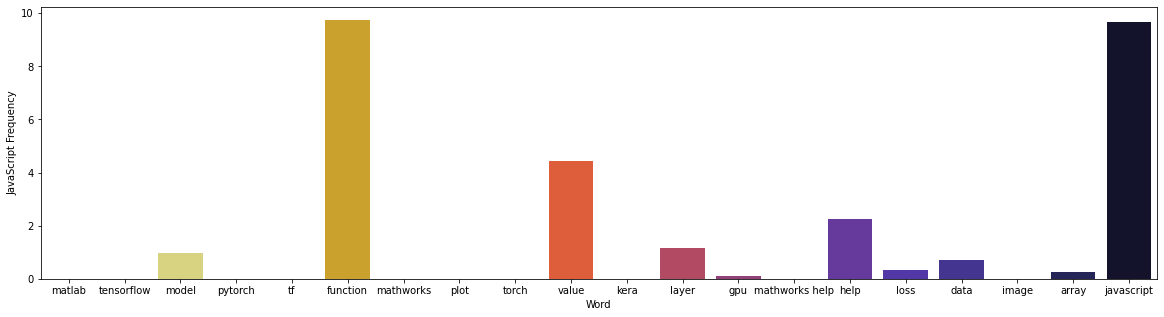

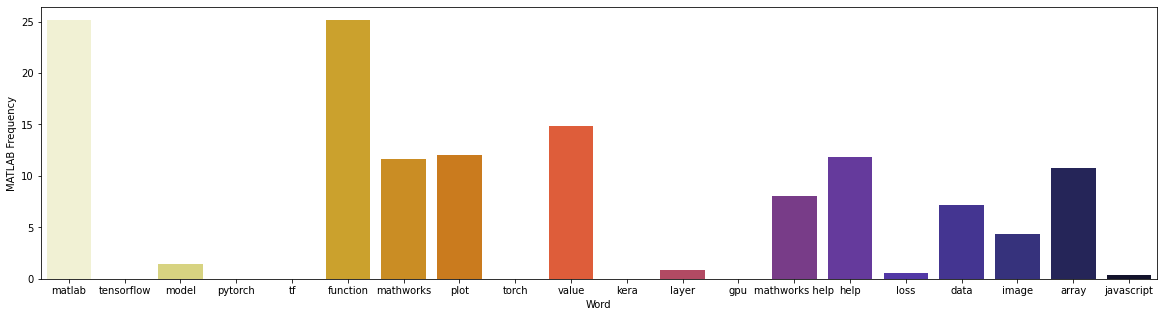

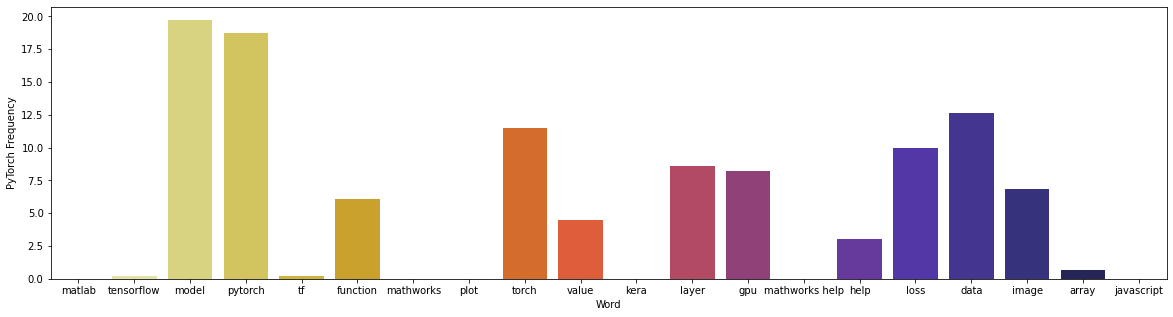

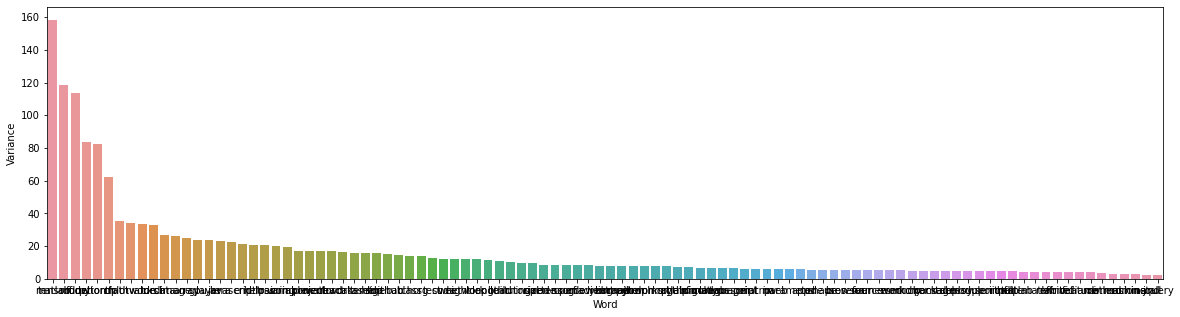

In [ ]:
bayes = NaiveBayes(4, stop_words)
bayes.fit(X, y, 1)


In [ ]:
y_pred = []
for i in x_test:
  y_pred.append(bayes.predict(i))

output = []

step = 0
for i in y_pred:
    if i == 0:
        output.append([step+1,"Javascript"])
    elif i == 1:
        output.append([step+1,"Matlab"])
    elif i == 2:
        output.append([step+1,"Pytorch"])
    elif i == 3:
        output.append([step+1,"Tensorflow"])
    step += 1
print(output)
df = pd.DataFrame(output)
df.to_csv('output.csv', index=False)

[[1, 'Javascript'], [2, 'Javascript'], [3, 'Javascript'], [4, 'Matlab'], [5, 'Matlab'], [6, 'Javascript'], [7, 'Javascript'], [8, 'Matlab'], [9, 'Javascript'], [10, 'Javascript'], [11, 'Pytorch'], [12, 'Javascript'], [13, 'Javascript'], [14, 'Javascript'], [15, 'Javascript'], [16, 'Javascript'], [17, 'Tensorflow'], [18, 'Javascript'], [19, 'Javascript'], [20, 'Matlab'], [21, 'Javascript'], [22, 'Javascript'], [23, 'Javascript'], [24, 'Javascript'], [25, 'Javascript'], [26, 'Javascript'], [27, 'Javascript'], [28, 'Matlab'], [29, 'Javascript'], [30, 'Javascript'], [31, 'Javascript'], [32, 'Javascript'], [33, 'Javascript'], [34, 'Javascript'], [35, 'Javascript'], [36, 'Javascript'], [37, 'Javascript'], [38, 'Pytorch'], [39, 'Javascript'], [40, 'Javascript'], [41, 'Javascript'], [42, 'Javascript'], [43, 'Javascript'], [44, 'Javascript'], [45, 'Matlab'], [46, 'Javascript'], [47, 'Javascript'], [48, 'Matlab'], [49, 'Javascript'], [50, 'Javascript'], [51, 'Javascript'], [52, 'Javascript'], [5

In [ ]:
print(x_test)

['ezno started pet project implementing feature tsc rust reading article rust came mind time look interesting example', 'differs typescript treat return annotation source truth allowing validly checked typescript doesntreat return annotation source truth example typescriptlang org play code gyvwdgxglglgmabatwbqembciwglybgapgecuazlctgaoaideauajalfqgllosbfia typescriptlang org play code gyvwdgxglglgmabatwbqembciwglybgapgecuazlctgaoaideauajalfqgllosbfia donunderstand typescript mean satisfies type type string number violet sky written function unknown string error unknown string return error function unknown string typeof return return', 'project page github kaleidawave bot action performed contact moderator message compose javascript question concern', 'real compliance issue company face require employee country spend day time restricted country itnot company pita', 'require office presence require person visa business owner sense difference posting gig contract hiring employee employee 

#Other ML test

Vectorization for train and test sets

In [ ]:
bayes = simple_vectorizer(4, stop_words)
train_vector = bayes.train_vector(X, y)
test_vector = bayes.test_vector(x_test)

In [ ]:
print(train_vector)
print(len(train_vector))
print(len(train_vector[0]))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
719
800


In [ ]:
print(test_vector)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Random Forest Test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(train_vector, y, test_size=0.2)
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(rf_X_train, rf_y_train)
y_pred = clf.predict(rf_X_test)
print(y_pred)
print(rf_y_test)
print(accuracy_score(rf_y_test, y_pred))

[3. 0. 0. 1. 0. 2. 0. 2. 1. 2. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 3.
 1. 2. 0. 1. 0. 0. 0. 0. 1. 3. 1. 3. 2. 0. 3. 3. 2. 1. 0. 0. 1. 2. 1. 0.
 0. 1. 3. 3. 2. 0. 0. 2. 0. 1. 3. 0. 0. 1. 2. 0. 2. 2. 1. 2. 0. 3. 1. 0.
 3. 2. 3. 2. 0. 2. 0. 2. 1. 3. 3. 2. 0. 2. 0. 3. 0. 1. 1. 2. 0. 0. 0. 2.
 1. 2. 2. 1. 0. 3. 1. 1. 2. 3. 0. 1. 2. 2. 2. 3. 3. 3. 0. 2. 0. 2. 2. 0.
 0. 3. 2. 2. 1. 3. 0. 2. 0. 1. 1. 3. 2. 0. 0. 0. 1. 1. 2. 2. 2. 0. 0. 1.]
[3. 0. 0. 1. 0. 3. 1. 2. 1. 2. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 3.
 1. 2. 0. 0. 0. 0. 3. 0. 3. 2. 1. 3. 2. 0. 3. 3. 3. 3. 0. 0. 1. 3. 1. 0.
 3. 1. 3. 3. 2. 0. 1. 3. 3. 1. 3. 3. 0. 1. 3. 0. 3. 2. 1. 2. 0. 2. 1. 0.
 2. 2. 3. 2. 1. 3. 0. 3. 1. 3. 1. 2. 0. 2. 0. 1. 0. 1. 0. 2. 0. 0. 0. 2.
 2. 2. 3. 1. 3. 3. 1. 1. 2. 3. 0. 1. 1. 2. 3. 3. 3. 3. 0. 2. 0. 2. 2. 0.
 2. 3. 2. 2. 1. 3. 1. 2. 0. 1. 1. 3. 2. 0. 0. 2. 1. 1. 2. 2. 3. 1. 0. 1.]
0.7638888888888888


Support Vector Machine

In [ ]:
from sklearn import svm
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(train_vector, y, test_size=0.2)
clf = svm.SVC()
clf.fit(rf_X_train, rf_y_train)
y_pred = clf.predict(rf_X_test)
print(y_pred)
print(rf_y_test)
print(accuracy_score(rf_y_test, y_pred))

[1. 2. 2. 2. 1. 1. 2. 1. 0. 3. 1. 0. 2. 0. 0. 0. 2. 3. 3. 1. 3. 3. 0. 1.
 2. 2. 0. 2. 0. 0. 0. 2. 0. 3. 0. 1. 0. 2. 0. 3. 2. 1. 0. 1. 2. 2. 3. 2.
 2. 0. 0. 0. 1. 3. 2. 1. 0. 2. 0. 2. 0. 2. 3. 1. 1. 1. 2. 0. 1. 1. 0. 2.
 0. 0. 1. 2. 1. 2. 0. 0. 2. 1. 1. 0. 0. 0. 1. 0. 3. 3. 1. 3. 2. 1. 1. 0.
 3. 2. 0. 1. 1. 3. 0. 1. 2. 0. 2. 1. 2. 2. 0. 2. 0. 2. 3. 3. 0. 0. 2. 1.
 0. 0. 1. 3. 3. 1. 2. 2. 3. 1. 2. 3. 2. 0. 0. 0. 0. 2. 0. 1. 0. 3. 1. 1.]
[1. 3. 3. 3. 1. 0. 2. 1. 0. 3. 1. 0. 2. 3. 0. 0. 2. 3. 2. 1. 3. 3. 0. 1.
 2. 2. 0. 2. 0. 0. 0. 2. 2. 2. 0. 1. 0. 3. 0. 3. 3. 1. 3. 3. 2. 3. 3. 2.
 2. 0. 0. 0. 1. 3. 2. 3. 3. 3. 3. 3. 1. 3. 3. 1. 1. 1. 2. 0. 1. 2. 0. 2.
 2. 0. 1. 3. 1. 2. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 2. 3. 1. 3. 2. 1. 1. 0.
 3. 2. 0. 1. 1. 3. 0. 1. 3. 0. 2. 1. 2. 3. 0. 2. 2. 2. 3. 3. 0. 0. 2. 1.
 2. 0. 1. 2. 3. 1. 3. 3. 3. 1. 2. 3. 3. 3. 0. 3. 0. 3. 0. 1. 0. 3. 1. 2.]
0.7361111111111112


Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(train_vector, y, test_size=0.2)
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(rf_X_train, rf_y_train)
y_pred = clf.predict(rf_X_test)
print(y_pred)
print(rf_y_test)
print(accuracy_score(rf_y_test, y_pred))

[2. 0. 1. 0. 2. 0. 1. 2. 2. 2. 3. 3. 0. 2. 3. 3. 3. 1. 0. 2. 0. 0. 2. 2.
 3. 2. 0. 2. 2. 2. 2. 2. 3. 2. 3. 0. 3. 1. 1. 0. 3. 0. 2. 1. 1. 2. 2. 2.
 0. 3. 2. 2. 0. 2. 0. 1. 2. 1. 2. 0. 0. 1. 2. 2. 2. 2. 3. 2. 3. 3. 3. 3.
 2. 2. 3. 3. 1. 0. 3. 2. 2. 3. 2. 0. 2. 3. 0. 3. 3. 1. 3. 2. 3. 0. 2. 3.
 3. 2. 1. 0. 3. 1. 0. 2. 2. 3. 1. 0. 1. 0. 3. 1. 2. 2. 3. 1. 0. 3. 0. 2.
 0. 2. 2. 2. 0. 1. 2. 0. 2. 2. 0. 0. 3. 0. 1. 2. 1. 3. 3. 3. 1. 0. 1. 0.]
[3. 0. 2. 0. 2. 3. 1. 1. 0. 2. 3. 0. 0. 3. 3. 3. 3. 2. 0. 1. 1. 1. 3. 2.
 1. 3. 0. 2. 2. 2. 2. 3. 3. 2. 3. 1. 3. 1. 1. 0. 2. 3. 2. 1. 1. 2. 2. 2.
 2. 2. 3. 3. 1. 2. 3. 1. 2. 3. 3. 0. 0. 1. 3. 2. 2. 3. 3. 1. 1. 3. 0. 3.
 2. 2. 3. 3. 1. 0. 0. 3. 2. 3. 1. 0. 3. 3. 0. 3. 3. 1. 3. 2. 3. 0. 2. 3.
 0. 2. 1. 0. 0. 1. 0. 2. 1. 3. 1. 0. 1. 2. 1. 1. 3. 0. 2. 1. 0. 1. 0. 1.
 3. 2. 1. 1. 3. 1. 3. 3. 2. 3. 0. 3. 0. 0. 1. 2. 1. 3. 2. 1. 1. 0. 0. 0.]
0.6041666666666666


Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(train_vector, y, test_size=0.25)
clf = GaussianNB()
clf.fit(rf_X_train, rf_y_train)
y_pred = clf.predict(rf_X_test)
print(y_pred)
print(rf_y_test)
print(accuracy_score(rf_y_test, y_pred))
print(confusion_matrix(rf_y_test, y_pred))

[2. 3. 3. 1. 0. 1. 1. 1. 0. 3. 2. 0. 2. 0. 0. 2. 1. 1. 2. 3. 2. 0. 3. 3.
 1. 2. 3. 0. 2. 0. 3. 3. 2. 1. 1. 0. 2. 3. 1. 1. 2. 0. 1. 1. 1. 2. 0. 0.
 1. 2. 3. 3. 3. 2. 3. 0. 2. 2. 3. 0. 0. 1. 3. 2. 3. 3. 0. 0. 2. 3. 3. 1.
 3. 2. 3. 2. 3. 2. 1. 2. 3. 2. 3. 1. 0. 3. 1. 0. 2. 3. 0. 1. 2. 3. 2. 3.
 3. 0. 1. 2. 2. 2. 2. 3. 0. 3. 1. 3. 2. 0. 2. 0. 2. 3. 3. 0. 1. 3. 2. 1.
 1. 2. 2. 0. 3. 0. 1. 0. 2. 3. 2. 3. 0. 0. 0. 0. 2. 0. 1. 1. 1. 3. 3. 3.
 1. 3. 0. 2. 1. 3. 1. 3. 3. 3. 0. 2. 1. 0. 3. 0. 0. 0. 1. 2. 0. 2. 0. 1.
 1. 1. 2. 2. 1. 2. 1. 2. 0. 3. 3. 3.]
[3. 3. 0. 3. 0. 1. 1. 1. 2. 1. 2. 2. 3. 1. 0. 3. 1. 1. 3. 3. 3. 0. 3. 3.
 0. 0. 3. 0. 1. 0. 2. 3. 2. 1. 1. 0. 3. 3. 1. 1. 2. 0. 3. 1. 1. 2. 0. 0.
 3. 2. 1. 3. 3. 2. 3. 0. 2. 2. 2. 0. 0. 1. 3. 3. 3. 0. 0. 1. 3. 3. 3. 1.
 3. 2. 3. 2. 3. 3. 1. 2. 0. 2. 3. 0. 0. 0. 0. 0. 2. 3. 0. 1. 3. 1. 2. 3.
 1. 2. 1. 2. 3. 0. 2. 2. 0. 3. 1. 2. 2. 2. 2. 0. 2. 3. 1. 0. 1. 3. 2. 0.
 1. 1. 2. 0. 3. 0. 1. 0. 2. 2. 0. 2. 0. 1. 1. 0. 3. 0. 1. 1. 1. 0. 3. 3.
 2. 2. 3. 2. 

#Stacking

tested with:
Random Forest,

Support Vector Machine,

Adaboost

In [ ]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(train_vector, y, test_size=0.2, random_state=42)

stack = []

rf = RandomForestClassifier(max_depth=20, random_state=0)
rf.fit(rf_X_train, rf_y_train)
rf_y_pred = rf.predict(rf_X_test)
stack.append(rf_y_pred)

ada = AdaBoostClassifier(n_estimators=200, random_state=0)
ada.fit(rf_X_train, rf_y_train)
y_pred = ada.predict(rf_X_test)
#stack.append(y_pred)

sv = svm.SVC()
sv.fit(rf_X_train, rf_y_train)
y_pred = sv.predict(rf_X_test)
#stack.append(y_pred)

pred = []
for i in range(len(y_pred)):
  top = 0
  current = 0
  current_list = []
  for j in range(len(stack)):
    current_list.append(stack[j][i])
  for j in range(len(stack)):
    if top < current_list.count(j):
      top = current_list.count(j)
      current = j
    
  pred.append(current)




In [ ]:
print(pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(accuracy_score(rf_y_test, pred))

0.19444444444444445


In [ ]:
print(accuracy_score(rf_y_test, rf_y_pred))

0.7222222222222222
